In [1]:
import os
import keras
import yaml
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
import src.features.build_features as build_features
from src.models.train_model import MonteCarloDropout, MCLSTM

# Load the Models

In [2]:
load_path = r"C:\Users\Noaja\Downloads\msci_project\tth-ML-project\models\wandb_models"

merged_model = keras.models.load_model(os.path.join(load_path, "merged-ce.h5"), 
                                       custom_objects={'MonteCarloDropout': MonteCarloDropout, 'MCLSTM': MCLSTM})

FNN_model = keras.models.load_model(os.path.join(load_path, "FNN-ce.h5"), 
                                       custom_objects={'MonteCarloDropout': MonteCarloDropout, 'MCLSTM': MCLSTM})

RNN_model = keras.models.load_model(os.path.join(load_path, "RNN-ce.h5"), 
                                       custom_objects={'MonteCarloDropout': MonteCarloDropout, 'MCLSTM': MCLSTM})

merged_model_mc = keras.models.load_model(os.path.join(load_path, "merged-ce-mc.h5"), 
                                       custom_objects={'MonteCarloDropout': MonteCarloDropout, 'MCLSTM': MCLSTM})

FNN_model_mc = keras.models.load_model(os.path.join(load_path, "FNN-ce-mc.h5"), 
                                       custom_objects={'MonteCarloDropout': MonteCarloDropout, 'MCLSTM': MCLSTM})

RNN_model_mc = keras.models.load_model(os.path.join(load_path, "RNN-ce-mc.h5"), 
                                       custom_objects={'MonteCarloDropout': MonteCarloDropout, 'MCLSTM': MCLSTM})

# Load Test Data

In [3]:
data = build_features.load_preprocessed_data(use_all_data=True)

In [4]:
test_size = 1_000

event_X_train, event_X_test = build_features.scale_event_data(data['event_X_train'], data['event_X_test'])
object_X_train, object_X_test = build_features.scale_object_data(data['object_X_train'], data['object_X_test'])
y_train, y_test = data['y_train'], data['y_test']

sample_event_X_test = event_X_test.iloc[:test_size]
sample_object_X_test = object_X_test[:test_size]
sample_y_test = data['y_test'].iloc[:test_size]

models = [(merged_model, [event_X_test, object_X_test], 'Merged Model'), (FNN_model, event_X_test, 'FNN Model'), (RNN_model, object_X_test, 'RNN Model')]
mc_models = [(merged_model_mc, [sample_event_X_test, sample_object_X_test], 'Merged Model'), (FNN_model_mc, sample_event_X_test, 'FNN Model'), (RNN_model_mc, sample_object_X_test, 'RNN Model')]

# Make Predictions

In [11]:
# Goes through each model and gets the mean prediction of n_samples predictions of the test set, then repeats n_preds times

n_preds = 10 # number of times to predict the test set
n_samples = 100 # number of models to sample from
auc_dicts = []

def mc_predict(X, model, n_models):
    preds = [model.predict(X).ravel() for _ in range(n_models)]
    return np.mean(preds, axis=0)

for model, X_test, model_name in tqdm(mc_models):
    for i in tqdm(range(n_preds)):
        preds = mc_predict(X_test, model, n_samples)
        auc_score = roc_auc_score(sample_y_test, preds)
        auc_dicts.append({'model': model_name, 'ROC AUC': auc_score})

auc_df = pd.DataFrame.from_records(auc_dicts)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

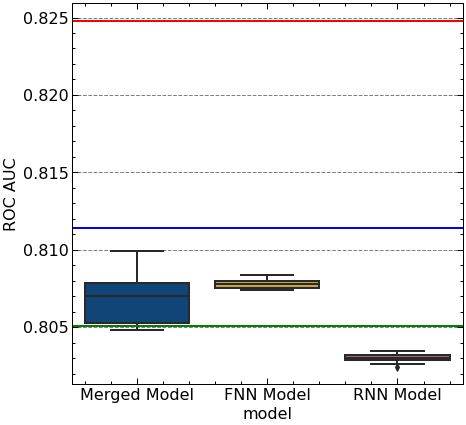

In [10]:
baseline_preds_merged = merged_model.predict([sample_event_X_test, sample_object_X_test])
baseline_auc_merged = roc_auc_score(sample_y_test, baseline_preds_merged)

baseline_preds_fnn = FNN_model.predict(sample_event_X_test)
baseline_auc_fnn = roc_auc_score(sample_y_test, baseline_preds_fnn)

baseline_preds_rnn = RNN_model.predict(sample_object_X_test)
baseline_auc_rnn = roc_auc_score(sample_y_test, baseline_preds_rnn)

with plt.style.context(['science', 'grid', 'notebook', 'high-contrast']):
    plt.figure(figsize=(7, 7))
    sns.boxplot(x="model", y="ROC AUC", data=auc_df)
    plt.axhline(y=baseline_auc_merged, color='r', linestyle='-')
    plt.axhline(y=baseline_auc_fnn, color='g', linestyle='-')
    plt.axhline(y=baseline_auc_rnn, color='b', linestyle='-')
    plt.show()

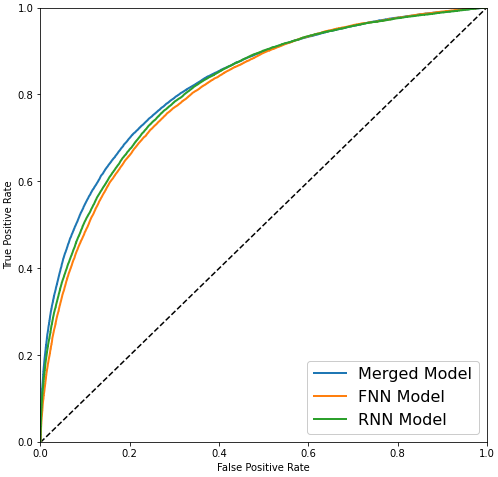

In [22]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], "k--")
plt.axis([0, 1, 0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

with plt.style.context(['science', 'grid', 'notebook', 'high-contrast']) as style:
    for model, X_test, model_name in models:
        preds = model.predict(X_test)
        fpr, tpr, _ = roc_curve(y_test, preds)
        plt.plot(fpr, tpr, label=model_name)
    
    plt.legend()
    plt.show()

  0%|          | 0/3 [00:00<?, ?it/s]

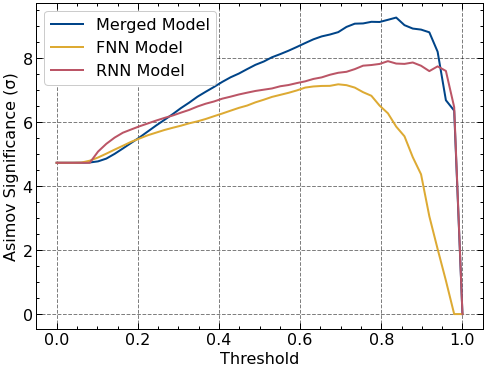

In [18]:
config = yaml.safe_load(open(r"C:\Users\Noaja\Downloads\msci_project\tth-ML-project\src\config.yaml"))

X_test = data["X_test"]
test_weight = X_test["xs_weight"].values
test_frac = len(y_test) / len(y_train)

n_thresholds = 50
thresholds = np.linspace(0, 1, n_thresholds)
significance = np.zeros(len(thresholds), dtype=float)

lum = config["data"]["lum"]
epsilon = 1e-5
labels = y_test.values

with plt.style.context(['science', 'grid', 'notebook', 'high-contrast']) as style:
    for model, X_test, model_name in tqdm(models):
        sg = np.zeros(len(thresholds))
        bg = np.zeros(len(thresholds))
        preds = model.predict(X_test)

        for i, threshold in enumerate(thresholds):
            sg[i] = (
                sum(
                    [
                        test_weight[j]
                        for j, (pred, label) in enumerate(zip(preds, labels))
                        if (pred >= threshold and label == 1)
                    ]
                )
                * lum
                / test_frac
            )
            bg[i] = (
                sum(
                    [
                        test_weight[j]
                        for j, (pred, label) in enumerate(zip(preds, labels))
                        if (pred >= threshold and label == 0)
                    ]
                )
                * lum
                / test_frac
            )

        significance = sg / np.sqrt(bg + epsilon)

        plt.plot(thresholds, significance, label=model_name)
        plt.ylabel("Asimov Significance (σ)")
        plt.xlabel("Threshold")

    plt.legend()
    plt.show()

In [ ]:
import pickle

metrics = pickle.load(open(r"C:\Users\Noaja\Downloads\msci_project\tth-ML-project\reports\figures\wandb_models\merged-ce.h5\metrics.pickle", "rb"))
metrics

{'Best Threshold': 0.836734693877551,
 'Best Significance': 9.256051555400072,
 'AUC': 0.8280048096998545}